In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import os

In [2]:
dt = 0.01
TR = 1
down_sample = int(TR/dt)
sigma = 1

In [3]:
def h(x):
    return np.tanh(x)

def NextTR(W, X_init, noise):
    X_res = X_init.copy()
    for i in range(down_sample):
        X_res = X_res + (-X_res + np.dot(W.T, h(X_res))) * dt + noise[i]
    return X_res

def RNN(W, X_init, length, pert_strength=1.0, pert_step=200):
    np.random.seed(0)
    n = len(X_init)
    X = [X_init]
    real_EC = np.zeros((n, n))
    pert_count = 0

    for i in range(1, length):
        noise = (sigma * np.sqrt(dt)) * np.random.normal(0, 1, (down_sample, n))
        X.append(NextTR(W, X[-1], noise))

        if i % pert_step == 0:
            pert_count += 1
            for j in range(n):
                perted_init = X[-2].copy()
                perted_init[j] += pert_strength
                real_EC[j] += NextTR(W, perted_init, noise) - X[-1]

    real_EC /= pert_count
    np.fill_diagonal(real_EC, 0)
    return np.array(X), real_EC

In [5]:
def RNN_heterogeneous_SNR(W, X_init, length, SNR_per_region, pert_strength=1.0, pert_step=200):
    """Different SNR for different regions"""
    np.random.seed(0)
    n = len(X_init)
    X = [X_init]
    real_EC = np.zeros((n, n))
    pert_count = 0

    noise_scales = 1.0 / SNR_per_region

    for i in range(1, length):
        noise = np.zeros((down_sample, n))
        for j in range(n):
            noise[:, j] = (noise_scales[j] * sigma * np.sqrt(dt)) * np.random.normal(0, 1, down_sample)

        X.append(NextTR(W, X[-1], noise))

        if i % pert_step == 0:
            pert_count += 1
            for j in range(n):
                perted_init = X[-2].copy()
                perted_init[j] += pert_strength
                real_EC[j] += NextTR(W, perted_init, noise) - X[-1]

    real_EC /= pert_count
    np.fill_diagonal(real_EC, 0)
    return np.array(X), real_EC

In [6]:
def apply_spatial_smoothing(signal, merge_groups):
    """
    Merge regions based on spatial smoothing
    Merge_groups: list of lists, e.g., [[0], [1,2], [3], [4,5]] merges R2+R3 and R5+R6
    """
    n_timesteps = signal.shape[0]
    n_merged = len(merge_groups)

    smoothed_signal = np.zeros((n_timesteps, n_merged))

    for i, group in enumerate(merge_groups):
        smoothed_signal[:, i] = np.mean(signal[:, group], axis=1)

    return smoothed_signal, merge_groups


def create_merge_groups(n_regions, merge_pairs):
    """
    Create merge groups from pairs
    merge_pairs: list of tuples indicating which regions to merge, e.g., [(1,2), (4,5)]
    """
    merged = set()
    groups = []

    for pair in merge_pairs:
        merged.update(pair)

    for i in range(n_regions):
        if i in merged:
            for pair in merge_pairs:
                if i in pair and list(pair) not in groups:
                    groups.append(list(pair))
        else:
            groups.append([i])

    return sorted(groups, key=lambda x: x[0])

In [7]:
def generate_combined_data(node_n=20, data_length=8000, random_seed=0,
                              snr_mode='heterogeneous', spatial_mode='merged'):
    """
    Generate RNN data with realistic SNR and spatial smoothing.

    snr_mode: 'uniform' or 'heterogeneous'
    spatial_mode: 'original' or 'merged'
    """
    np.random.seed(random_seed)

    SC = np.random.normal(0, 1/np.sqrt(node_n), (node_n, node_n))
    np.fill_diagonal(SC, 0)
    init = np.random.normal(0, 1, (node_n))

    if snr_mode == 'heterogeneous':
        SNR_per_region = np.random.uniform(5, 20, node_n)
        signal, real_EC = RNN_heterogeneous_SNR(SC, init, data_length, SNR_per_region)
    else:
        signal, real_EC = RNN(SC, init, data_length)
        SNR_per_region = None

    if spatial_mode == 'merged':
        n_merges = node_n // 5
        merge_pairs = [(i*2, i*2+1) for i in range(n_merges)]
        merge_groups = create_merge_groups(node_n, merge_pairs)
        smoothed_signal, groups = apply_spatial_smoothing(signal, merge_groups)

        return {
            'signal': signal,
            'smoothed_signal': smoothed_signal,
            'SC': SC,
            'real_EC': real_EC,
            'SNR': SNR_per_region,
            'merge_groups': merge_groups,
            'original_regions': node_n,
            'merged_regions': len(merge_groups)
        }
    else:
        return {
            'signal': signal,
            'SC': SC,
            'real_EC': real_EC,
            'SNR': SNR_per_region,
            'original_regions': node_n
        }

In [8]:
def export_combined_data(data_dict, prefix, output_dir='./sim_data'):
    """Save generated data"""
    import os
    os.makedirs(output_dir, exist_ok=True)

    np.savetxt(f'{output_dir}/{prefix}_signal.txt', data_dict['signal'])
    np.savetxt(f'{output_dir}/{prefix}_SC.txt', data_dict['SC'])
    np.savetxt(f'{output_dir}/{prefix}_real_EC.txt', data_dict['real_EC'])

    if data_dict['SNR'] is not None:
        np.savetxt(f'{output_dir}/{prefix}_SNR.txt', data_dict['SNR'])

    if 'smoothed_signal' in data_dict:
        np.savetxt(f'{output_dir}/{prefix}_smoothed_signal.txt', data_dict['smoothed_signal'])
        with open(f'{output_dir}/{prefix}_merge_groups.txt', 'w') as f:
            for group in data_dict['merge_groups']:
                f.write(','.join(map(str, group)) + '\n')

In [10]:
if __name__ == '__main__':
    node_n = 20
    data_length = 8000

    scenarios = [
        ('baseline', 'uniform', 'original'),
        ('hetero_snr', 'heterogeneous', 'original'),
        ('spatial_smooth', 'uniform', 'merged'),
        ('combined', 'heterogeneous', 'merged')
    ]

    for i, (name, snr_mode, spatial_mode) in enumerate(scenarios):
        print(f"Generating {name}...")
        data = generate_combined_data(node_n, data_length, random_seed=i,
                                        snr_mode=snr_mode, spatial_mode=spatial_mode)
        export_combined_data(data, f'{name}_seed{i:02d}', './sim_data')

Generating baseline...
Generating hetero_snr...
Generating spatial_smooth...
Generating combined...


In [15]:
def flat_without_diagonal(matrix):
    n = matrix.shape[0]
    flattened = []
    for i in range(n):
        for j in list(range(i)) + list(range(i + 1, n)):
            flattened.append(matrix[i][j])
    return np.array(flattened)

def visualize_scenario(data_dict, scenario_name):
    SC = data_dict['SC']
    real_EC = data_dict['real_EC']

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    sns.heatmap(SC, cmap='RdBu_r', center=0, ax=axes[0],
                cbar_kws={'label': 'Strength'}, square=True)
    axes[0].set_title(f'{scenario_name}: Structural Connectivity (SC)',
                      fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Target Node')
    axes[0].set_ylabel('Source Node')

    sns.heatmap(real_EC, cmap='RdBu_r', center=0, ax=axes[1],
                cbar_kws={'label': 'Strength'}, square=True)
    axes[1].set_title(f'{scenario_name}: Effective Connectivity (EC)',
                      fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Target Node')
    axes[1].set_ylabel('Source Node')

    sc_flat = flat_without_diagonal(SC)
    ec_flat = flat_without_diagonal(real_EC)
    r_value, p_value = pearsonr(sc_flat, ec_flat)

    axes[2].scatter(sc_flat, ec_flat, alpha=0.5, s=20)
    axes[2].set_xlabel('SC Strength', fontsize=12)
    axes[2].set_ylabel('EC Strength', fontsize=12)
    axes[2].set_title(f'SC vs EC Correlation\nr = {r_value:.3f}, p = {p_value:.2e}',
                      fontsize=14, fontweight='bold')
    axes[2].axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
    axes[2].axvline(x=0, color='gray', linestyle='--', linewidth=0.5)
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    return r_value, p_value

def analyze_ec_properties(real_EC, scenario_name):
    EC_no_diag = real_EC.copy()
    np.fill_diagonal(EC_no_diag, 0)
    exc = EC_no_diag[EC_no_diag > 0]
    inh = EC_no_diag[EC_no_diag < 0]

    print(f'Excitatory: {len(exc)} ({len(exc)/(len(exc)+len(inh))*100:.1f}%)')
    print(f'Inhibitory: {len(inh)} ({len(inh)/(len(exc)+len(inh))*100:.1f}%)')
    print(f'Range: [{EC_no_diag.min():.4f}, {EC_no_diag.max():.4f}]')


BASELINE


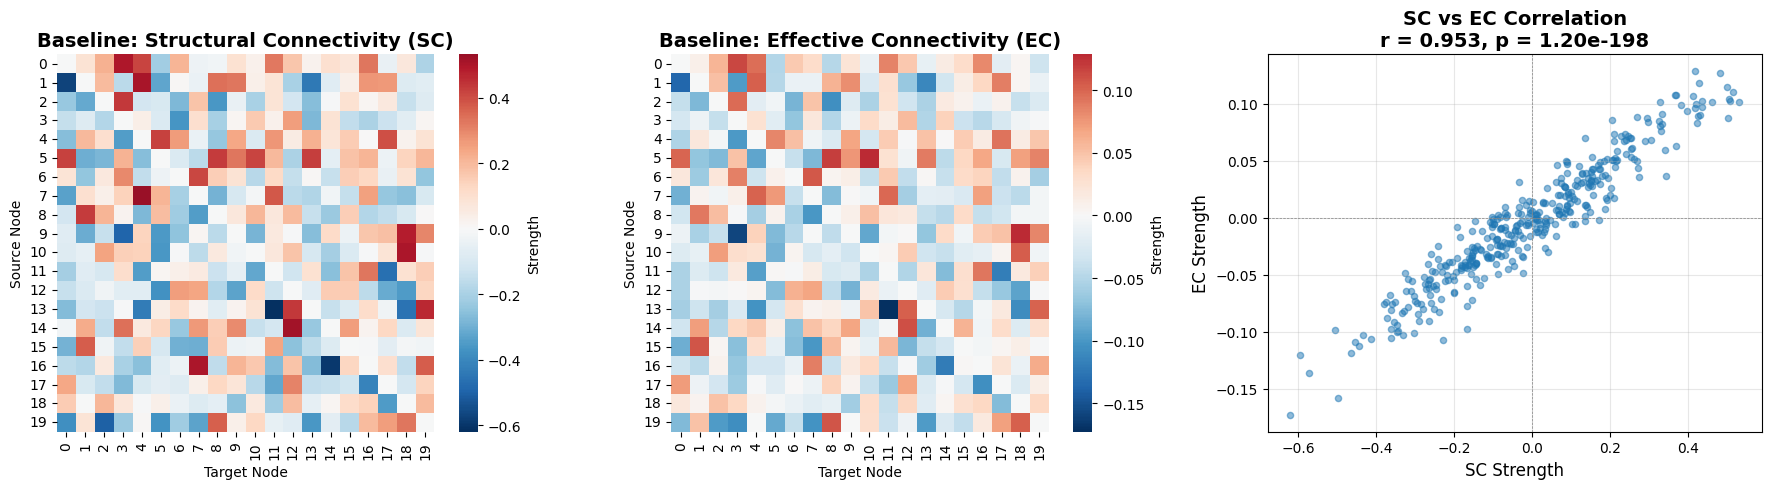

Excitatory: 170 (44.7%)
Inhibitory: 210 (55.3%)
Range: [-0.1726, 0.1285]

HETERO_SNR
SNR: 5.1 - 18.7


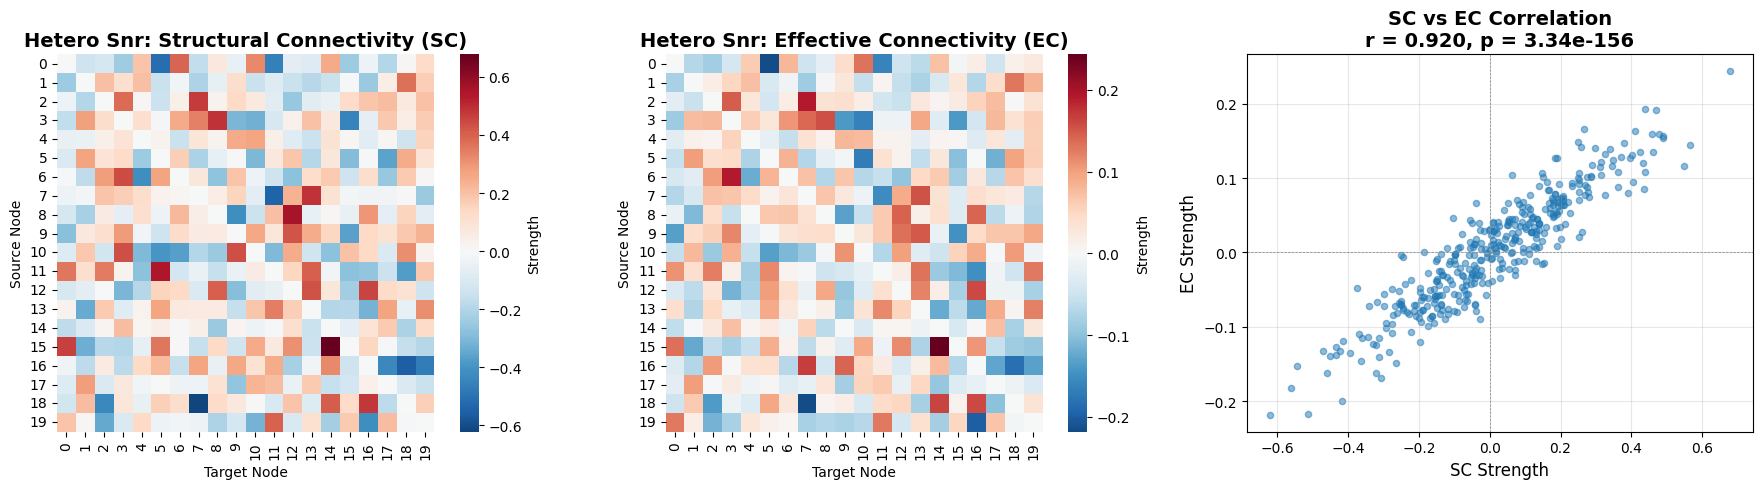

Excitatory: 200 (52.6%)
Inhibitory: 180 (47.4%)
Range: [-0.2180, 0.2433]

SPATIAL_SMOOTH
Regions: 20 → 16


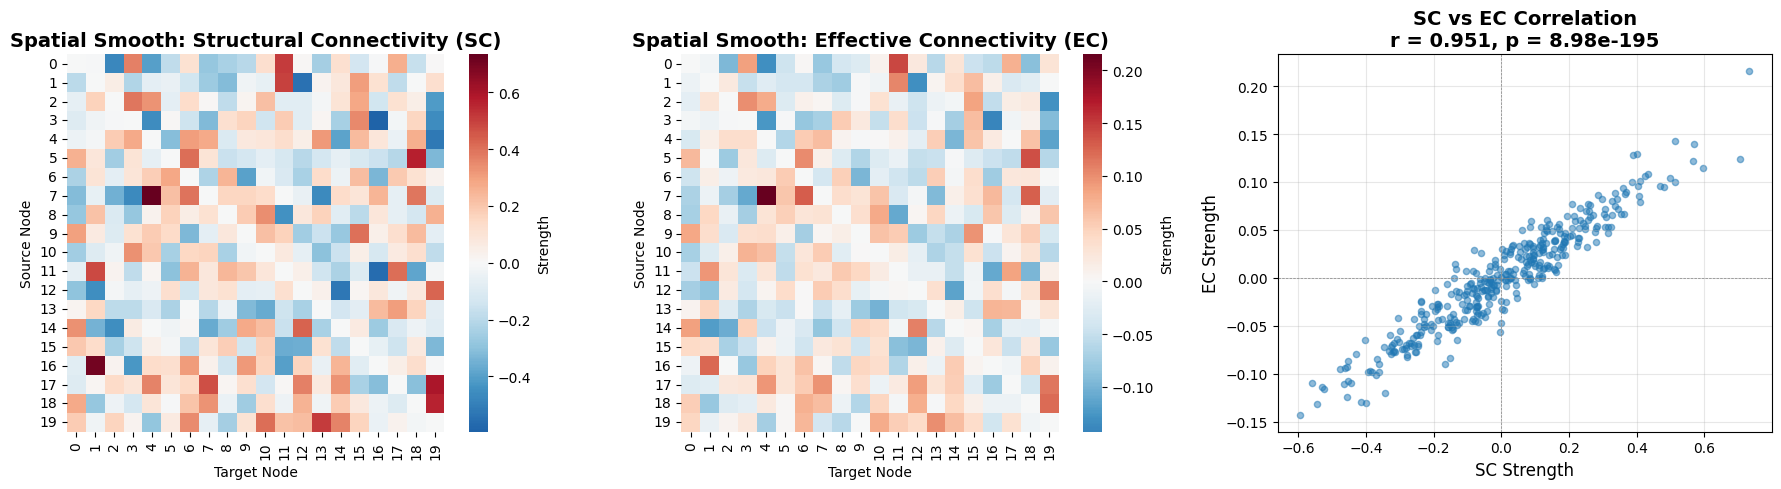

Excitatory: 190 (50.0%)
Inhibitory: 190 (50.0%)
Range: [-0.1424, 0.2152]

COMBINED
SNR: 7.1 - 19.8
Regions: 20 → 16


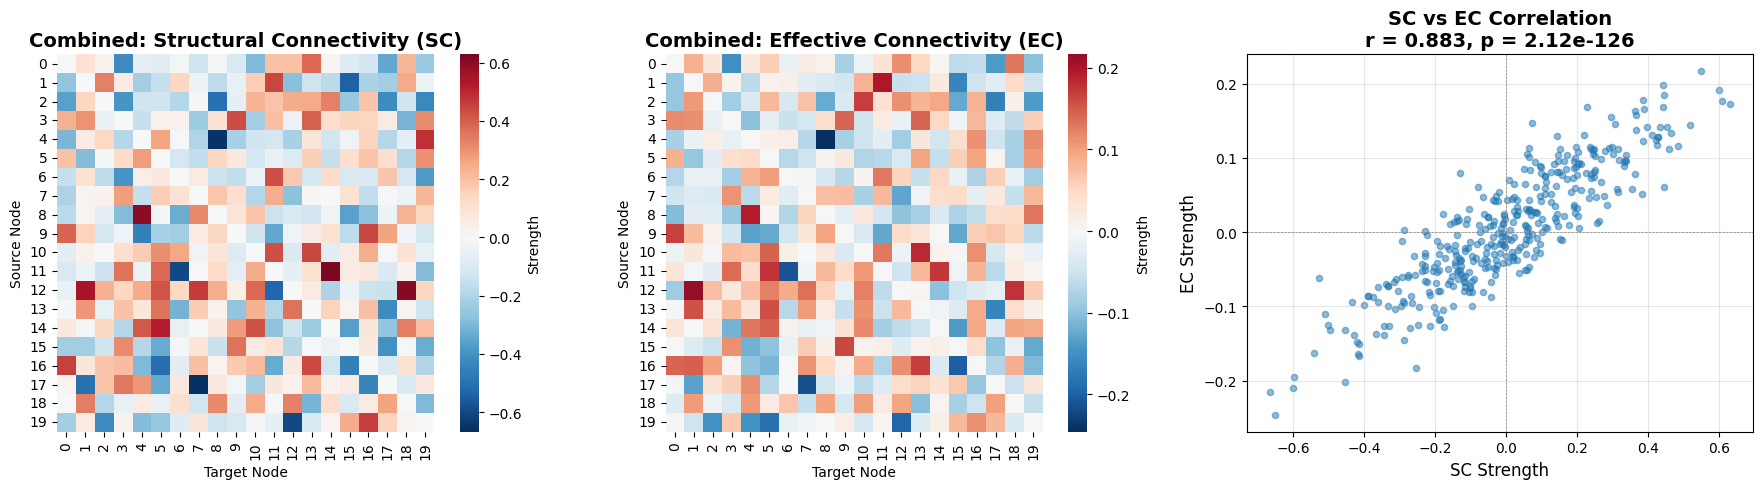

Excitatory: 194 (51.1%)
Inhibitory: 186 (48.9%)
Range: [-0.2456, 0.2165]


In [16]:
scenarios = ['baseline', 'hetero_snr', 'spatial_smooth', 'combined']
correlations = {}

for i, scenario in enumerate(scenarios):
    print(f'\n{scenario.upper()}')

    prefix = f'./sim_data/{scenario}_seed{i:02d}'
    SC = np.loadtxt(f'{prefix}_SC.txt')
    signal = np.loadtxt(f'{prefix}_signal.txt')
    real_EC = np.loadtxt(f'{prefix}_real_EC.txt')
    data = {'SC': SC, 'signal': signal, 'real_EC': real_EC}

    if scenario in ['hetero_snr', 'combined']:
        SNR = np.loadtxt(f'{prefix}_SNR.txt')
        data['SNR'] = SNR
        print(f'SNR: {SNR.min():.1f} - {SNR.max():.1f}')

    if scenario in ['spatial_smooth', 'combined']:
        smoothed = np.loadtxt(f'{prefix}_smoothed_signal.txt')
        data['smoothed_signal'] = smoothed
        print(f'Regions: {signal.shape[1]} → {smoothed.shape[1]}')

    r, p = visualize_scenario(data, scenario.replace('_', ' ').title())
    correlations[scenario] = r
    analyze_ec_properties(real_EC, scenario)

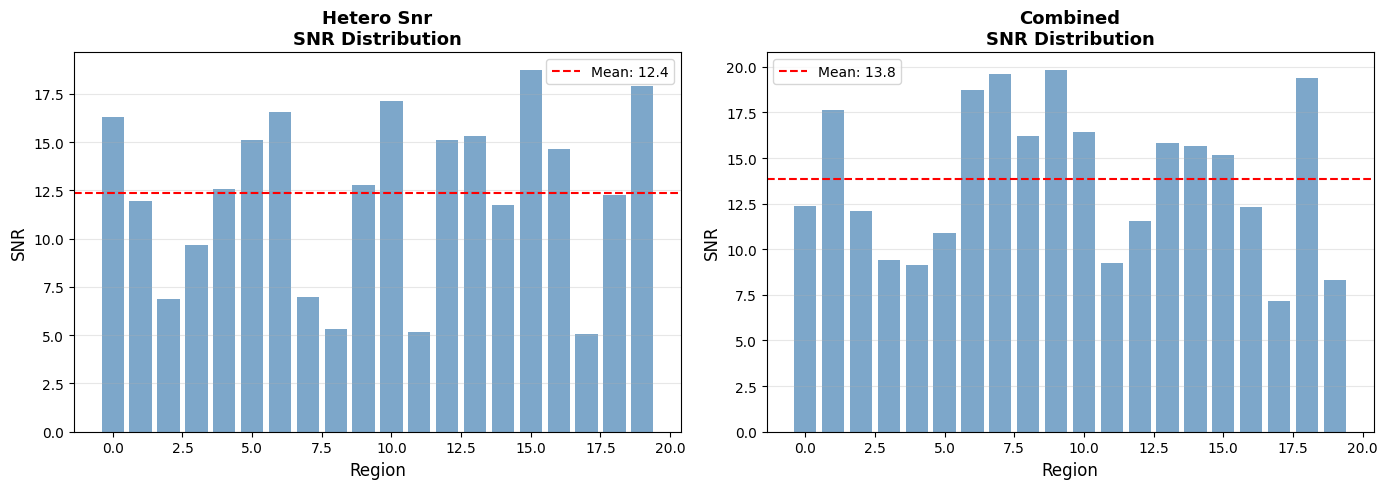

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
scenarios_with_snr = ['hetero_snr', 'combined']

for idx, scenario in enumerate(scenarios_with_snr):
    i = ['baseline', 'hetero_snr', 'spatial_smooth', 'combined'].index(scenario)
    SNR = np.loadtxt(f'./sim_data/{scenario}_seed{i:02d}_SNR.txt')
    axes[idx].bar(range(len(SNR)), SNR, color='steelblue', alpha=0.7)
    axes[idx].axhline(y=SNR.mean(), color='red', linestyle='--',
                     label=f'Mean: {SNR.mean():.1f}')
    axes[idx].set_xlabel('Region', fontsize=12)
    axes[idx].set_ylabel('SNR', fontsize=12)
    axes[idx].set_title(f'{scenario.replace("_", " ").title()}\nSNR Distribution',
                       fontsize=13, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()